# Meta-analysis of COVID-19 papers

### Project for Management and Analysis of Physics Datasets
***

By: LamBHrusco gang



## Cluster setup

emmò la situa si complica

In [191]:
import pandas as pd
import numpy  as np 
import time
import matplotlib.pyplot as plt
import dask
#import nltk 
#nltk.download('stopwords')
import dask.bag as db
import json
import os
from nltk.corpus import stopwords
import geopandas
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable


import warnings
warnings.filterwarnings("ignore")

In [2]:
client.restart()

NameError: name 'client' is not defined

In [2]:
from dask.distributed import Client, LocalCluster
#client = Client('localhost:8786')
cluster = LocalCluster(n_workers=4) 
client  = Client(cluster)

#client = Client()
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 3.84 GiB
Comm: tcp://127.0.0.1:46337,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 3.84 GiB
Comm: tcp://127.0.0.1:39259,Total threads: 1
Dashboard: http://127.0.0.1:36025/status,Memory: 0.96 GiB
Nanny: tcp://127.0.0.1:41971,


## Read of papers from JSON files

We will import JSON files and tranform them into Dask Bags

In [ ]:
!head -n 4 COVID_papers/0000b93c66f991236db92dc16fa6db119b27ca12.json

In [ ]:
#Read of the papers
! rm foo.bar
! ls COVID_papers >> foo.bar
#smaller dataset for various tests without the whole cluster
! rm foo2.bar
! ls COVID_papers_radio_edit >> foo2.bar

In [3]:

#from urllib.request import urlopen

#b = db.read_text("foo.bar").map(lambda string: string.strip()).map(lambda string: "COVID_papers/"+string).map(open).map(json.load)
#b = db.read_text("https://raw.githubusercontent.com/Luca-Negri/Meta_Analysis_of_COVID_papers/main/foo.bar").map(lambda string: string.strip()).map(lambda string: "Meta_Analysis_of_COVID_papers/COVID_papers/"+string).map(open).map(json.load)

b = db.read_text("https://raw.githubusercontent.com/Luca-Negri/Meta_Analysis_of_COVID_papers/main/foo2.bar").map(lambda string: string.strip()).map(lambda string: os.path.join('COVID_papers_radio_edit', string)).map(open).map(json.load)

#! rm dummy.mapd
#! ls COVID_papers >> dummy.mapd 
#with open('dummy.mapd') as file:
#    flist = ['https://raw.githubusercontent.com/Luca-Negri/Meta_Analysis_of_COVID_papers/main/COVID_papers/'+i.strip() for i in file]
#b = db.from_sequence(flist).map(urlopen).map(lambda x: x.read()).map(json.loads)

#b = b.repartition(len(flist))#select the number of partitions 
b

dask.bag<load-52..., npartitions=1>

In [187]:
path_file = PATH = os.path.join('COVID_papers_radio_edit', '*.json')

#b = db.read_text("https://raw.githubusercontent.com/Luca-Negri/Meta_Analysis_of_COVID_papers/main/foo2.bar").map(lambda string: string.strip()).map(lambda string: os.path.join('COVID_papers_radio_edit', string)).map(open).map(json.load)


with open('dummy.mapd') as file:
    flist = ['json1line_COVID_papers/'+i.strip() for i in file]
with open('dummy.mapd') as file:
    #flistgit = ['https://raw.githubusercontent.com/Luca-Negri/Meta_Analysis_of_COVID_papers/main/json1line_COVID_papers/'+i.strip() for i in file]
    flistgit = ['json1line_COVID_papers/'+i.strip() for i in file]

#select the number of partitions 
b = db.read_text(flist).map(json.loads).repartition(40) 

In [188]:
time1 = time.time()
print(b.take(20)[1]['body_text'][4]['text'])
print(time.time() - time1)

Así pues, el panorama residencial es el de un nivel de atención que, asiste a un número muy importante de PPMM con necesidades sociales y sanitarias, pero que no goza de la regulación, financiación, provisión, capacitación de personal, ni de los sistemas de inspección que precisaría, situación que parece similar en otros países 6 . La atención médica especializada se encuentra en un punto que necesita muchas mejoras 7 . Siendo así la en condiciones habituales, sus carencias se agudizarán mucho más ante cualquier amenaza externa.
2.0483455657958984


In [192]:
def concatenate_text(paper_dict):
    
    """Function to tranform the body text field of the json files into a clean and usable 
        format, by concatenating the sections and removing unwanted characters
        
        
        Arguments:
        paper_dict ::: python dictionary containing the paper read from the JSON files
        
        
        Returns:
        paper_dict ::: now the "body_text" contains all the text sections concatenated
        
        
        """
    #print('Concatenate!')
    body_text_list  = paper_dict['body_text'] #read of the text
    
    #concatenation of every section into one text file
    total_text = ''
    for text_section in body_text_list:
        total_text += text_section['text']
        
    total_text = total_text.lower()#lowercase everything
        
    # deteleting all unwanted characters
    
    forbidden_chars = ".,()[]:*><;°%/+="
    for forbidden_ch in forbidden_chars:
        
        total_text = total_text.replace(forbidden_ch,"")
        
    paper_dict['body_text'] = total_text
    
    return paper_dict
    
    
def word_count(paper_dict):
     
    """Function to count the occurencies of each word in the document using numpy functions
    
        Arguments:
        
        paper_dict ::: python dictionary containing the paper read from the JSON files
    
        
        Retrurns
        
        word_counts ::: python dictionary containing each word as key and the number of occurencies as value
    
    """
    
    import numpy as np # define right namespace
    body_text = paper_dict['body_text']# get the text
    text_list = body_text.split() # transform into a list
    
    ### MODIFICHE FEDE ###
    stopw = stopwords.words('english') 
    otherw = stopw + ['fig', 'et', 'al', 'also', 'may', 'using', 'use', 'used', 'one', 'two', 'however', 'can', 'could'] + [str(i) for i in range(11)] 
    text_list = [i for i in text_list if i not in otherw]
    ######################
    
    words, counts = np.unique(text_list, return_counts  = True) # count the words
    
    word_counts = {key : count for key,count in zip(words, counts)} # transform into a dictionary
    #paper_dict['word_count'] = word_counts # add dictionary  to json
    
    return word_counts
    
    
    

In [193]:
def reduce_counts(word_list1,word_list2):
    
    """Combines the results od two dictionaries"""
    
    #print('io pure!')
    #obtaining the keys
    keys1 = word_list1.keys()
    keys2 = word_list2.keys()
    
    word_list_out = word_list1
    
    #add one value to the other
    for key2 in keys2:
            #check if already present
            if key2 not in keys1:
                word_list_out[key2] = word_list2[key2]
            else:
                word_list_out[key2] += word_list2[key2]
    return word_list_out
        
    
    

In [194]:
time1 = time.time()
b_conc  = b.map(concatenate_text).map(word_count)
b_conc.take(2)[1]
print(time.time() - time1)

1.8089699745178223


In [195]:
time1 = time.time()
b_conc  = b.map(concatenate_text).map(word_count)
b_count = b_conc.fold(reduce_counts)
oh = b_count.compute()
print(time.time() - time1)

distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


177.3133819103241


In [19]:
oh_sort = dict(sorted(oh.items(), key=lambda item: item[1])[::-1])

words_related_to_research = ['et','al','fig','data','study','number','model','results'
                             ,'figure','p','t','reported','public','table','studies','higher'
                            ,'different','population','shown','period','analysis','information']

words_related_to_COVID    = ['mers-cov','covid-19','patients','infection',
                             'rate','health','cases','virus','disease','human','pandemic',
                            'viral','autophagy','growth','response','nodules','lockdown',
                            'contact','cells','care','case','positive','protein','stem','epidemic'
                            ,'transimission','dna']

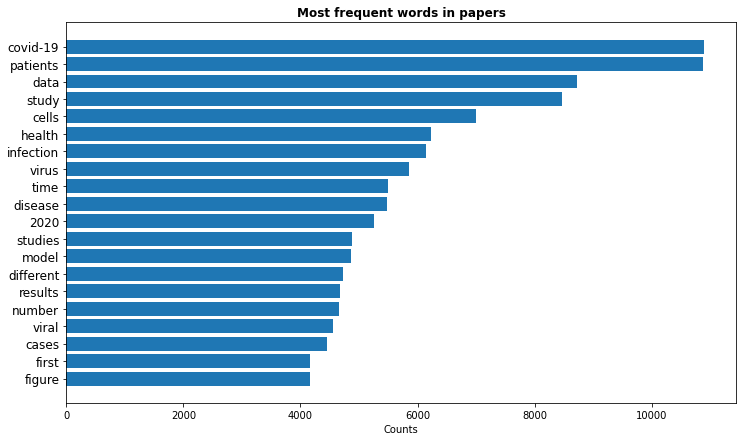

In [197]:
n_to_plot = 20
n_low = 0

list_of_vals = list(oh_sort.values())[n_low:n_to_plot]
list_of_keys = list(oh_sort.keys())[n_low:n_to_plot]

clist = []

for key in list_of_keys:
    
    if key in words_related_to_COVID:
        clist.append('orange')
    elif key in words_related_to_research:
        clist.append('green')
    else:
        clist.append('blue')
    

plt.subplots(figsize=[12,7])
my_cmap = plt.get_cmap("inferno")
plt.title('Most frequent words in papers', fontweight='bold')
plt.xlabel('Counts')
#plt.barh(list_of_keys[::-1],list_of_vals[::-1],color=clist[::-1])
plt.barh(list_of_keys[::-1],list_of_vals[::-1])#, color=clist[::-1])
#plt.xticks(rotation=60)
plt.yticks(fontsize=12)
plt.show()

## Nations represented in research

We will now try to gather information on the research, from wich country it comes form

In [21]:
def country_getter(paper_dict):
    
    authors = paper_dict['metadata']['authors']
    countries = {}
    for author in authors:
        try:
            
            country = author['affiliation']['location']['country']

                
        except:
            country = 'Not Available'
            
        if country not in countries.keys():
            country = country.replace(' Correspondence', '').replace(' Correspondencia', '').replace(';','').replace(':','')
            country = country.replace('. •', '').replace('.','').replace(' ²Our Research','').replace(' A B S T R A C T', '')
            c_list = country.split(', ')
            for c in c_list:
                if c not in countries.keys():
                    countries[c] = 1
                else:
                    countries[c] +=1
        else:
            countries[country]+=1
    
    return countries
    

In [22]:
countries = b.map(country_getter).fold(reduce_counts).compute()

distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [244]:
def country_proc(df):
    
    # We want to merge the different country names to a single country
    replacements     = {'PR China':'China',"People's Republic of China":'China','China (':'China','P R China':'China',
                    'ROC':'Taiwan',
                    'Mexico City':'Mexico',
                    'Japan (':'Japan',
                    'UK':'United Kingdom', 'UK)':'United Kingdom', 'Public Health England':'United Kingdom',
                    'UK A R':'United Kingdom','Scotland':'United Kingdom',
                    'Spain Address':'Spain', 'España':'Spain', 'Spain email':'Spain', 'Spain 11':'Spain',
                    '4 Switzerland':'Switzerland',
                    'U.S.A':'USA', 'United States of America':'USA', 'United States':'USA', 'The United States of America':'USA',
                    'UT':'USA', 'Ann Arbor':'USA', 'Unites States of America':'USA',
                    'Brasil':'Brazil', 'Brazil R':'Brazil', 'Brazil (':'Brazil',
                    'Österreich':'Austria', 'Austria *Correspondence':'Austria',
                    'Italien':'Italy', 'Italia':'Italy',
                    'Iran (the Islamic Republic of':'Iran',
                    'Osmaniye':'Turkey', 'Gokhan':'Turkey',
                    'the Netherlands':'Netherlands', 'The Netherlands':'Netherlands',
                    'Korea':'South Korea', 'Republic of Korea':'South Korea',
                    'SA Avenida Italia':'Uruguay',
                    'Canada ²Our Research':'Canada',
                    'Valledupar Colombia':'Colombia',
                    'New Caledonia':'France',
                    'Schweden':'Sweden', 
                    'Norwegen':'Norway',
                    '7 Germany':'Germany', 'Deutschland':'Germany'
                    }
    # The computed dataframe is cleaned and the counts are merged. Not available countries
    # are removed.
    df     = df.replace(replacements)
    df_new = df.groupby(by='Country',axis=0).sum().sort_values(by='N', ascending=False)
    df_new = df_new.loc[df_new.index != 'Not Available']
    n_to_plot = 20

    #First plot: most represented countries in research
    list_of_vals = df_new.values.flatten()[0:n_to_plot]
    list_of_keys = list(df_new.index)[0:n_to_plot]

    plt.figure(figsize=(12,7))
    plt.barh(list_of_keys[::-1], list_of_vals[::-1])
    plt.title('Most represented countries in research', fontweight='bold')
    plt.xlabel('Counts')

    plt.show()
    
    # Second plot: least represented countries in research
    a = df_new[df_new['N']==1]

    list_of_vals = a.values.flatten()
    list_of_keys = list(a.index)

    plt.figure(figsize=(12,7))
    plt.barh(list_of_keys, list_of_vals)
    plt.title('Least represented countries in research', fontweight='bold')
    plt.xlabel('Counts')

    plt.show()
    return df_new
    
def country_map(df_new):
    
    # A geodataframe is created for world map
    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    
    # Some pre-processing of our data
    data_for_map = df_new.rename(index = str, columns = {'Country':'name', 'N':'N'})
    data_for_map['name'] = data_for_map.index
    data_for_map.loc['USA','name'] = 'United States of America'
    data_for_map.loc['Czech Republic', 'name'] = 'Czechia'
    data_for_map
    data_for_map.index = data_for_map['name']
    
    # geodataframe and dataset are merged
    merged = world.set_index('name').join(data_for_map.set_index('name'))
    
    # plot
    vmin, vmax = 0.1, 720
    fig, ax = plt.subplots(1, figsize=(15,15))
    ax.set_title('Most and least represented countries', fontweight = 'bold')


    merged.plot(ax=ax, column='N', cmap='PuBu',  norm=colors.LogNorm(vmin=vmin, vmax=vmax))

    sm = plt.cm.ScalarMappable(cmap='PuBu', norm=colors.LogNorm(vmin=vmin, vmax=vmax))
    sm._A = []

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(sm,fraction=0.046, pad=0.04, cax=cax)

    ax.axis('off')
    

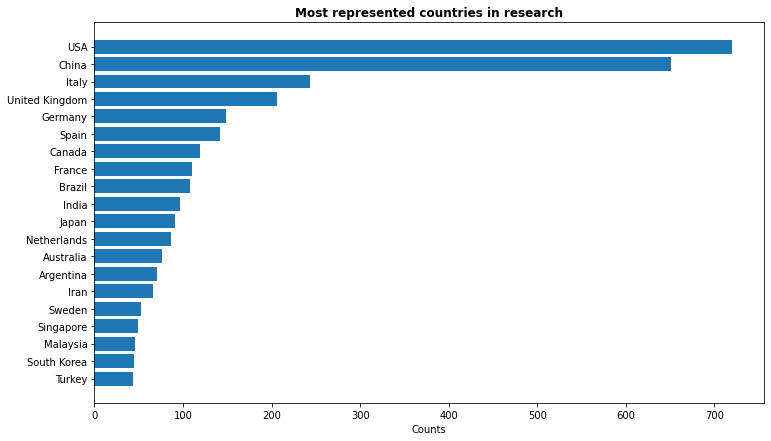

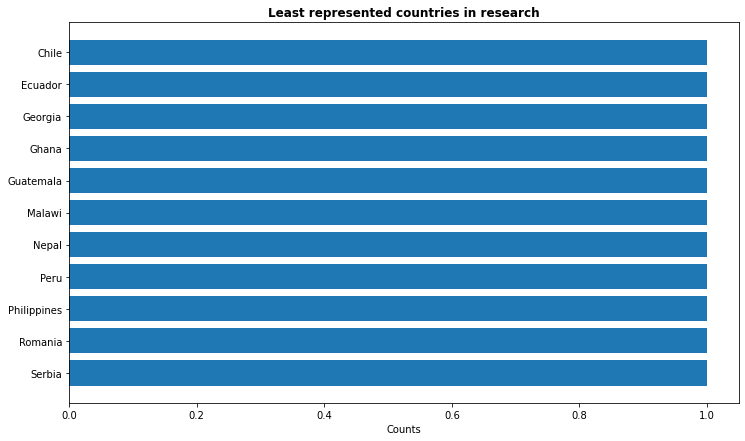

In [245]:
df_new = country_proc(pd.DataFrame(list(countries.items()),columns = ['Country','N']))

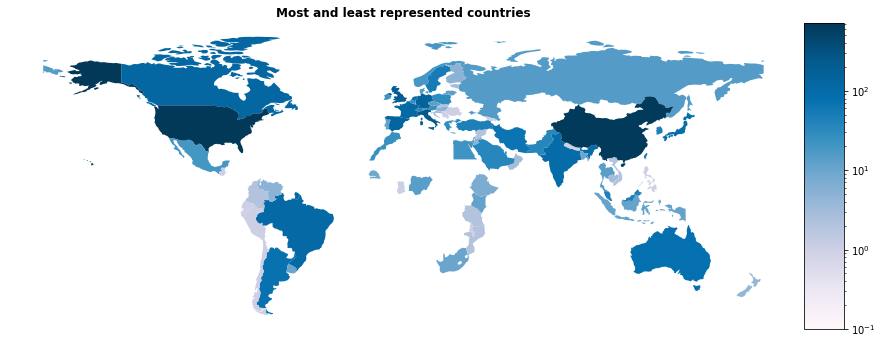

In [246]:
country_map(df_new)

### Institutions represented in research

In [212]:
def institution_getter(paper_dict):
    
    authors = paper_dict['metadata']['authors']
    institutions = {}
    for author in authors:
        try:
            
            inst = author['affiliation']['institution']
            if inst == '':
                inst = 'Not Available'

                
        except:
            inst = 'Not Available'
            
        if inst not in institutions.keys():

        else:
            institutions[inst]+=1
    
    return institutions
    

In [213]:
institutions = b.map(institution_getter).fold(reduce_counts).compute()

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [250]:
def institution_proc(df):


    df_new = df.groupby(by='Institution',axis=0).sum().sort_values(by='N', ascending=False)
    df_new = df_new.loc[df_new.index != 'Not Available']
    
    n_to_plot = 20

    list_of_vals = df_new.values.flatten()[0:n_to_plot]
    list_of_keys = list(df_new.index)[0:n_to_plot]

    plt.figure(figsize=(14,8))
    plt.barh(list_of_keys[::-1], list_of_vals[::-1])
    plt.title('Most represented institutions in research', fontweight='bold')
    plt.xlabel('Counts')

    plt.show()
    
    print('The least represented institutions in research (a single citation) are', len(df_new[df_new['N']==1]), '.')

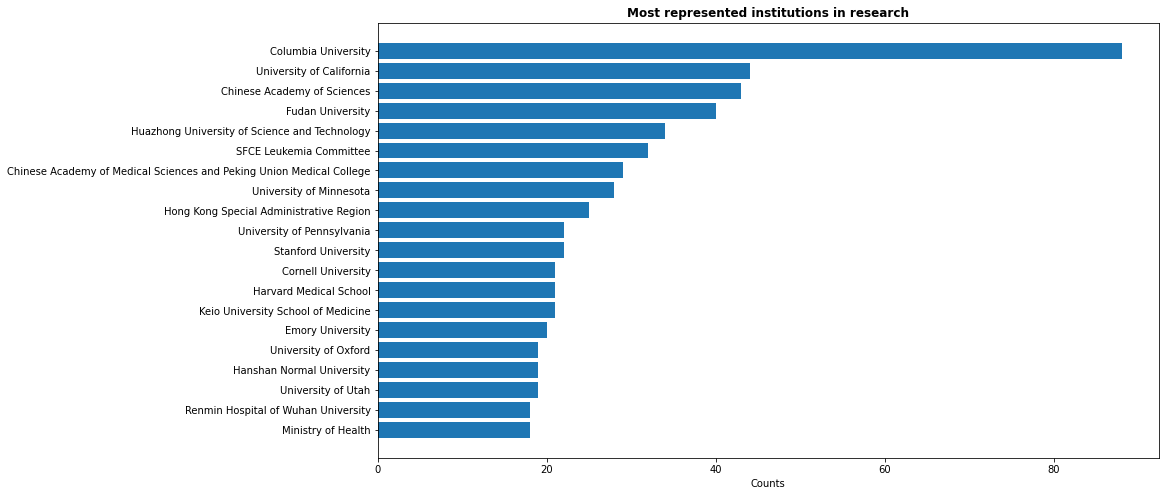

The least represented institutions in research (a single citation) are 545 .


In [252]:
df     = pd.DataFrame(list(institutions.items()),columns = ['Institution','N'])
institution_proc(df)

## NLP

In [4]:
import io
import os
import dask.bag as db
import dask.dataframe as dd
import json
import time
from nltk.corpus import stopwords

In [5]:
def load_wordlist(fname):
    words = {}
    
    with io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore') as fin:
        n, d = map(int, fin.readline().split())
        # n = number of words
        # d = vector dimension
        
        
        embeddings = np.zeros((n, d), dtype=np.float32)
        
        for i, line in enumerate(fin):
            tokens = line.rstrip().split(' ')
            words[tokens[0]] = i
            embeddings[i, :] = np.array(tokens[1:], dtype=np.float32) 
                
        return words, embeddings

In [9]:
t1 = time.time()
words, embedding = load_wordlist('wiki.en.vec')
print('Time = ', np.round((time.time() - t1)/60), 's')

KeyboardInterrupt: 

In [7]:
path_file = PATH = os.path.join('COVID_papers_radio_edit', '*.json')

#b = db.read_text("https://raw.githubusercontent.com/Luca-Negri/Meta_Analysis_of_COVID_papers/main/foo2.bar").map(lambda string: string.strip()).map(lambda string: os.path.join('COVID_papers_radio_edit', string)).map(open).map(json.load)


with open('dummy.mapd') as file:
    flist = ['json1line_COVID_papers/'+i.strip() for i in file]
with open('dummy.mapd') as file:
    flistgit = ['https://raw.githubusercontent.com/Luca-Negri/Meta_Analysis_of_COVID_papers/main/json1line_COVID_papers/'+i.strip() for i in file]

#select the number of partitions 
b = db.read_text(flist).map(json.loads).repartition(45) 

In [8]:
b

dask.bag<reparti..., npartitions=45>

In [ ]:
with open('words_finder.json','w') as f:
    
    f.write(json.dumps(words))


In [9]:
words_reloded = json.load(open('words_finder.json'))

In [10]:
words = words_reloded

In [13]:
def sanitize_text(text):
    forbidden_chars = ".,()[]:*><;°%/+"
    for forbidden_ch in forbidden_chars :
        text = text.replace(forbidden_ch,"")
    return(text.lower())

def extract_title(b):
    title = b['metadata']['title']
    title = sanitize_text(title)
    #print(title)
    title = title.split()
    return {'paper_id':b['paper_id'], 'title': title}

def get_ind_list(b):
    # words = parole con indicy
    title = b['title']
    ind = []
    for word in title:
        #if word != '' and word in pre_words:            
            #ind.append(words[word])
            #print(word)
        ind.append(words.get(word))
    return {'paper_id':b['paper_id'], 'title': ind}


def get_ind_list2(title):
    # words = parole con indicy
    words = json.load(open('words_finder.json'))
    ind = []
    for word in title:
        #if word != '' and word in pre_words:            
            #ind.append(words[word])
            #print(word)
        ind.append(words.get(word))
    return ind



def get_ind_list3(title):
    words = client.gather(w_future)
    ind = []
    for word in title:
        #if word != '' and word in pre_words:            
            #ind.append(words[word])
            #print(word)
        ind.append(words.get(word))
    return ind    
   
def get_embeddings_list(b):
    
    inds = b['title']
    
    fp = io.open('wiki.en.vec', 'r', encoding='utf-8', newline='\n', errors='ignore')
    
    emb = []
    
    inds = list(filter(None, inds))
    
    if len(inds)==0:
        return []
    m = max(inds)
    for i, line in enumerate(fp):
        if i in inds:
            tokens = line.rstrip().split(' ')
            emb.append(np.array(tokens[1:], dtype=np.float32))
        elif i > m:
            break
    fp.close()
    return {'paper_id':b['paper_id'], 'title_embedding': emb}



In [14]:
b.map(extract_title).map(get_ind_list).take(10)

({'paper_id': '0000b93c66f991236db92dc16fa6db119b27ca12',
  'title': [11471, 6, 64166, 5546, 1999, 24174, 364889, 3102, None]},
 {'paper_id': '0000fcce604204b1b9d876dc073eb529eb5ce305', 'title': []},
 {'paper_id': '000a0fc8bbef80410199e690191dc3076a290117',
  'title': [None,
   12,
   1697,
   42430,
   16980,
   17,
   8471,
   2823,
   5206,
   7,
   17068,
   462,
   6,
   38469,
   82989]},
 {'paper_id': '000affa746a03f1fe4e3b3ef1a62fdfa9b9ac52a',
  'title': [11347,
   134,
   37939,
   5695,
   7,
   13995,
   4,
   None,
   1179,
   11471,
   360,
   11,
   None,
   9995,
   47160,
   38724,
   7,
   None,
   270759,
   24,
   12,
   98,
   1052,
   6,
   3293,
   23,
   None,
   11,
   None]},
 {'paper_id': '000b0174f992cb326a891f756d4ae5531f2845f7',
  'title': [485,
   191,
   12,
   7583,
   626,
   4,
   None,
   760,
   274,
   11874,
   4829,
   86742,
   None,
   296062,
   7,
   9562,
   9337,
   15135,
   6,
   100114,
   25976,
   8925,
   17,
   2133,
   22664]},
 {'pa

In [15]:
prova = b.map(extract_title).map(get_ind_list).map(get_embeddings_list).take(9)
prova[2]

{'paper_id': '000a0fc8bbef80410199e690191dc3076a290117',
 'title_embedding': [array([-0.12278  , -0.036748 ,  0.20728  , -0.018277 , -0.0016348,
          0.023735 , -0.03712  , -0.28608  , -0.19088  , -0.068688 ,
          0.061755 , -0.052416 ,  0.16867  , -0.1108   , -0.11308  ,
         -0.27392  , -0.30827  ,  0.18204  ,  0.096594 ,  0.29725  ,
         -0.050727 ,  0.023406 , -0.33813  , -0.10599  , -0.11249  ,
          0.066722 ,  0.14842  , -0.31099  , -0.09372  ,  0.0027705,
         -0.16806  ,  0.20955  , -0.23591  ,  0.070785 , -0.25399  ,
         -0.1121   , -0.12584  , -0.11348  , -0.13821  , -0.37261  ,
          0.1712   ,  0.091039 ,  0.12721  ,  0.033067 , -0.033074 ,
          0.03804  , -0.18015  ,  0.043457 ,  0.099211 ,  0.037043 ,
         -0.0035936, -0.35885  , -0.1046   , -0.24532  ,  0.12304  ,
          0.11229  ,  0.0019709,  0.16426  ,  0.051579 ,  0.081311 ,
         -0.0034787, -0.17466  ,  0.30059  , -0.23183  , -0.017487 ,
          0.28647  ,  0.399

In [16]:
title_embeddings = b.map(extract_title).map(get_ind_list).map(get_embeddings_list).compute()

In [17]:
title_embeddings[2]

{'paper_id': '000a0fc8bbef80410199e690191dc3076a290117',
 'title_embedding': [array([-0.12278  , -0.036748 ,  0.20728  , -0.018277 , -0.0016348,
          0.023735 , -0.03712  , -0.28608  , -0.19088  , -0.068688 ,
          0.061755 , -0.052416 ,  0.16867  , -0.1108   , -0.11308  ,
         -0.27392  , -0.30827  ,  0.18204  ,  0.096594 ,  0.29725  ,
         -0.050727 ,  0.023406 , -0.33813  , -0.10599  , -0.11249  ,
          0.066722 ,  0.14842  , -0.31099  , -0.09372  ,  0.0027705,
         -0.16806  ,  0.20955  , -0.23591  ,  0.070785 , -0.25399  ,
         -0.1121   , -0.12584  , -0.11348  , -0.13821  , -0.37261  ,
          0.1712   ,  0.091039 ,  0.12721  ,  0.033067 , -0.033074 ,
          0.03804  , -0.18015  ,  0.043457 ,  0.099211 ,  0.037043 ,
         -0.0035936, -0.35885  , -0.1046   , -0.24532  ,  0.12304  ,
          0.11229  ,  0.0019709,  0.16426  ,  0.051579 ,  0.081311 ,
         -0.0034787, -0.17466  ,  0.30059  , -0.23183  , -0.017487 ,
          0.28647  ,  0.399

In [ ]:
words_df = pd.DataFrame(words,index=[0])

In [ ]:
w_future = client.scatter(words,broadcast=True)

In [ ]:

w = dd.from_pandas(words_df,npartitions=1)

In [ ]:
    emb_list = []
    for inds in ind_list:
        fp = io.open('wiki.en.vec', 'r', encoding='utf-8', newline='\n', errors='ignore')
        emb = []
        m = max(inds)
        for i, line in enumerate(fp):
            if i in inds:
                tokens = line.rstrip().split(' ')
                word = tokens[0]
                emb.append(np.array(tokens[1:], dtype=np.float32))
            elif i > m:
                break

        fp.close()
        emb_list.append(emb)

In [ ]:
from gensim.models import KeyedVectors

In [ ]:
init = time.time()

trained_word_dict = KeyedVectors.load_word2vec_format('wiki.en.vec')

end = time.time()

print("Time needed to load the model: ", np.round((end - init)/60), " m.")